<a href="https://colab.research.google.com/github/sanadelph/pcg_binary_classification/blob/main/pcg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import sys
!{sys.executable} -m pip install deap
!{sys.executable} -m pip install bitstring
!{sys.executable} -m pip install python_speech_features

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from random import shuffle
import math
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Input, Dense, Bidirectional, Dropout
from keras.models import Model, Sequential
from deap import base, creator, tools, algorithms
from bitstring import BitArray
from scipy.io import wavfile
import scipy.signal
from scipy.stats import bernoulli
from sklearn.preprocessing import StandardScaler
import IPython
from python_speech_features import mfcc
import librosa
import matplotlib.pyplot as plt


drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5867 sha256=325272be8ddd559526118b0c14e85f2585e3d515d78f75a49c72d04512c1220c
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Mounted at /content/drive


In [ ]:
def load_data(folder, trainingFolders):
  waves=[]
  audioDataset=[]
  for tf in trainingFolders:
    dataset = pd.read_csv('/content/drive/MyDrive/{}/{}/REFERENCE.csv'.format(folder,tf), header=None, names =['filename', 'target'])
    waves.append(dataset)

  wav=pd.concat(waves)
  wav.target.replace(to_replace=-1, value=0, inplace=True) #replacing -1 lable of Normal wave to 0
  print(wav)

  for tf in trainingFolders:
      for filename,target in zip(wav.filename,wav.target):
          path_wav = "/content/drive/MyDrive/{}/{}/{}.wav".format(folder,tf,filename)
          if os.path.exists(path_wav):
            sampFreq, audio = wavfile.read(path_wav)            # Return the sample rate (in samples/sec) and data from a WAV file
            label=target
            audioDataset.append({"audio":audio,"label": label,"samplingRate":sampFreq})
  return audioDataset

audioDataset=load_data('training',['training-a','training-b','training-c','training-d','training-e','training-f'])

    filename  target
0      a0001       1
1      a0002       1
2      a0003       1
3      a0004       1
4      a0005       1
..       ...     ...
109    f0110       0
110    f0111       0
111    f0112       0
112    f0113       0
113    f0114       0

[3240 rows x 2 columns]


Abnormal PCG Signal


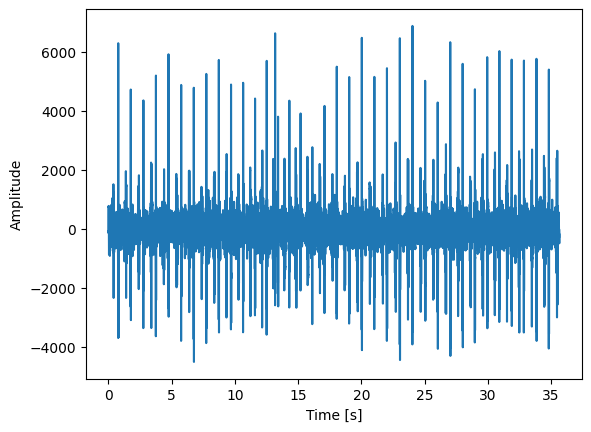



Normal PCG Signal


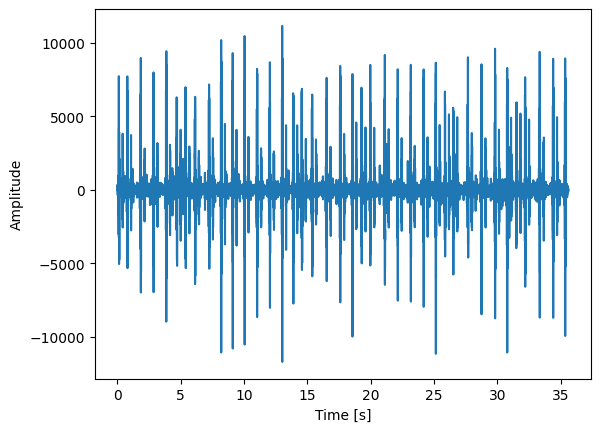

In [ ]:
print("Abnormal PCG Signal")
abnormal= audioDataset[0]
length = abnormal['audio'].shape[0] / abnormal['samplingRate']
time = np.linspace(0., length, abnormal['audio'].shape[0])
plt.plot(time, abnormal['audio'])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

print("\n\nNormal PCG Signal")
normal= audioDataset[10]
length = normal['audio'].shape[0] / normal['samplingRate']
time = np.linspace(0., length, normal['audio'].shape[0])
plt.plot(time, normal['audio'])
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

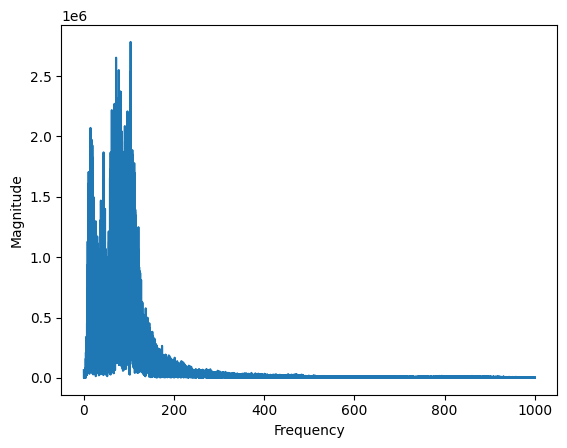

In [ ]:
fft=np.fft.fft(audioDataset[10]['audio'])
spectrum=np.abs(fft)
frequency = np.linspace(0, audioDataset[0]['samplingRate'], len(spectrum))

left_spectrum=spectrum[:int(len(frequency)/2)]
left_frequency=frequency[:int(len(frequency)/2)]
plt.plot(left_frequency, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()





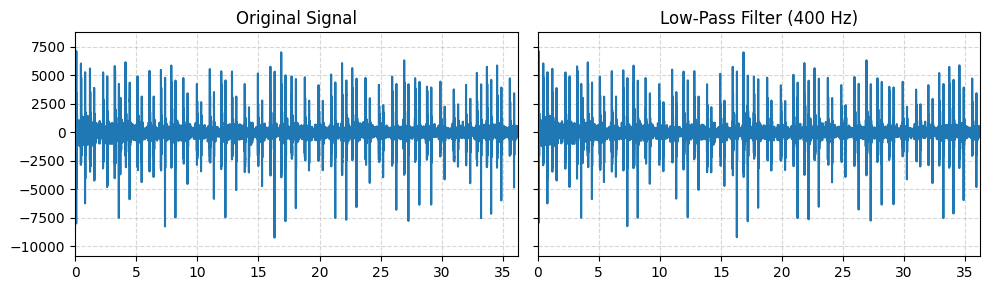

In [ ]:
filteredSignals=[]
times=[]
order=5
cutoff=400
for audio in audioDataset:
  times.append(np.arange(len(audio['audio']))/audio['samplingRate'])
  sos = scipy.signal.butter(order, cutoff, 'lowpass', fs=audio['samplingRate'], output='sos')
  filteredSignals.append(scipy.signal.sosfiltfilt(sos, audio['audio']))

# Apply a 400 Hz low-pass filter to the original data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
ax1.plot(times[400], audioDataset[400]['audio'])
ax1.set_title("Original Signal")
ax1.margins(0, .1)
ax1.grid(alpha=.5, ls='--')
ax2.plot(times[400], filteredSignals[400])
ax2.set_title("Low-Pass Filter (400 Hz)")
ax2.grid(alpha=.5, ls='--')
plt.tight_layout()
plt.show()


In [ ]:
mfcc_features = list()
labels = []
max_sequence_length = 500
num_mfcc=13

for i,audio in enumerate(audioDataset):
  MFCCs = mfcc(filteredSignals[i],
               audio['samplingRate'],
               nfft=1024,
               numcep=num_mfcc)
  if MFCCs.shape[0] < max_sequence_length:
    pad_width = max_sequence_length - MFCCs.shape[0]
    temp = np.pad(MFCCs, pad_width=((0, pad_width),(0, 0)))
  else:
    temp = MFCCs[:max_sequence_length,:]
  mfcc_features.append({"label": audio['label'], "mfcc": temp})

mfcc_features = np.array(mfcc_features)
# print(mfcc_features[500]['mfcc'])
# print(len(mfcc_features))
# print(mfcc_features[209]['mfcc'].shape)


In [ ]:
shuffle(mfcc_features)
train_files = list()
size = (8*len(mfcc_features))/10
train_features = mfcc_features[0:int(size)]
test_features = mfcc_features[int(size):]
train_size = 0
for feature in train_features:
    train_files.append({'label': feature["label"], 'feature': feature["mfcc"] })
    train_size += 1
x_train = np.zeros((train_size, max_sequence_length ,13))
y_train = np.zeros((train_size))
i = 0
for train_file in train_files:
    x_train[i,:,:] = train_file['feature']
    y_train[i] = train_file['label']
    i += 1

test_files = list()
test_size = 0
for feature in test_features:
  test_files.append({'label': feature["label"], 'feature': feature["mfcc"] })
  test_size += 1
x_test = np.zeros((test_size, max_sequence_length ,13))
y_test = np.zeros((test_size))
i = 0
for test_file in test_files:
    x_test[i,:,:] = test_file['feature']
    y_test[i] = test_file['label']
    i += 1


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(2592, 500, 13)
(2592,)
(648, 500, 13)
(648,)


In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test_scaled = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
print(x_train_scaled.shape)
print(x_test_scaled.shape)

(2592, 500, 13)
(648, 500, 13)


In [ ]:
# def baseline_classifier(x_train,y_train,x_test,y_test):
#   stratified_classifier = DummyClassifier(strategy='stratified', random_state=42)
#   stratified_classifier.fit(x_train, y_train)
#   y_pred = stratified_classifier.predict(x_test)
#   accuracy = accuracy_score(y_test, y_pred)
#   return accuracy


def train_evaluate(ga_individual_solution):
    # Decode GA solution to integer for num_neurons, epochs
    num_neurons1_bits = BitArray(ga_individual_solution[:7])
    num_neurons2_bits = BitArray(ga_individual_solution[7:14])
    epoch_bits = BitArray(ga_individual_solution[14:])

    num_neurons1 = num_neurons1_bits.uint
    num_neurons2 = num_neurons2_bits.uint
    epoch = epoch_bits.uint


    print('\nNum of neurons1: ', num_neurons1,'\nNum of neurons2',num_neurons2, '\nEpoch:', epoch)

    # Return fitness score of 0 if num_neurons1 < 0 or num_neurons2 < 0 or epoch < 10
    if num_neurons1 <= 0 or num_neurons2 <= 0 or epoch < 10:
      return 0,

    #split into train and validation (80/20)
    X_train,X_test,Y_train,Y_test=train_test_split(x_train_scaled,y_train,test_size=0.2)

    model = Sequential()
    model.add(LSTM(units=num_neurons1, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=num_neurons2))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
    model.summary()

    history=model.fit(X_train, Y_train, epochs=epoch, verbose=0)
    # Y_pred = model.predict(X_test)
    val_accuracy=model.evaluate(x=X_test,y=Y_test)[1]
    print(f"Validation accuracy: ", val_accuracy)


    return val_accuracy,


population_size = 8
num_generations = 4
gene_length = 19
# As we are trying to minimize the RMSE score, that's why using -1.0.
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register('max', np.max)
stats.register('avg', np.mean)
# Create the hall of fame object
hof = tools.HallOfFame(5)
population = toolbox.population(n = population_size)
r, logbook = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, stats=stats,
    halloffame=hof, verbose = False)



/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Num of neurons1:  7 
Num of neurons2 95 
Epoch: 0

Num of neurons1:  35 
Num of neurons2 114 
Epoch: 3

Num of neurons1:  34 
Num of neurons2 102 
Epoch: 8

Num of neurons1:  25 
Num of neurons2 102 
Epoch: 20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 500, 25)             │           3,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 500, 25)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 102)                 │          52,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 102)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             103 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,227 (219.64 KB)

 Trainable params: 56,227 (219.64 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8673 - loss: 0.3138
Validation accuracy:  0.8747591376304626

Num of neurons1:  20 
Num of neurons2 46 
Epoch: 7

Num of neurons1:  29 
Num of neurons2 68 
Epoch: 2

Num of neurons1:  100 
Num of neurons2 77 
Epoch: 14


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 500, 100)            │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 500, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 77)                  │          54,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 77)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              78 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,502 (392.59 KB)

 Trainable params: 100,502 (392.59 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8693 - loss: 0.3087
Validation accuracy:  0.8805394768714905

Num of neurons1:  36 
Num of neurons2 23 
Epoch: 14


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 500, 36)             │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 500, 36)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 23)                  │           5,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 23)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,744 (49.78 KB)

 Trainable params: 12,744 (49.78 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8557 - loss: 0.3242
Validation accuracy:  0.8458574414253235

Num of neurons1:  36 
Num of neurons2 23 
Epoch: 14


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 500, 36)             │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 500, 36)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 23)                  │           5,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 23)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,744 (49.78 KB)

 Trainable params: 12,744 (49.78 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8663 - loss: 0.2749
Validation accuracy:  0.8612716794013977

Num of neurons1:  9 
Num of neurons2 122 
Epoch: 3

Num of neurons1:  36 
Num of neurons2 23 
Epoch: 14


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 500, 36)             │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 500, 36)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 23)                  │           5,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 23)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,744 (49.78 KB)

 Trainable params: 12,744 (49.78 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8603 - loss: 0.3227
Validation accuracy:  0.863198459148407

Num of neurons1:  100 
Num of neurons2 77 
Epoch: 14


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 500, 100)            │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 500, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 77)                  │          54,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 77)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              78 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,502 (392.59 KB)

 Trainable params: 100,502 (392.59 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8915 - loss: 0.3125
Validation accuracy:  0.8863198161125183

Num of neurons1:  21 
Num of neurons2 31 
Epoch: 10


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 500, 21)             │           2,940 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 500, 21)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 31)                  │           6,572 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 31)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              32 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,544 (37.28 KB)

 Trainable params: 9,544 (37.28 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8758 - loss: 0.3111
Validation accuracy:  0.8863198161125183

Num of neurons1:  94 
Num of neurons2 65 
Epoch: 14


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 500, 94)             │          40,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 500, 94)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 65)                  │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,274 (321.38 KB)

 Trainable params: 82,274 (321.38 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8819 - loss: 0.2850
Validation accuracy:  0.8863198161125183

Num of neurons1:  100 
Num of neurons2 77 
Epoch: 14


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 500, 100)            │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 500, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 77)                  │          54,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 77)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              78 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,502 (392.59 KB)

 Trainable params: 100,502 (392.59 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8698 - loss: 0.3044
Validation accuracy:  0.8670520186424255

Num of neurons1:  100 
Num of neurons2 77 
Epoch: 14


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 500, 100)            │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 500, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 77)                  │          54,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 77)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              78 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,502 (392.59 KB)

 Trainable params: 100,502 (392.59 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8910 - loss: 0.2640
Validation accuracy:  0.8863198161125183

Num of neurons1:  82 
Num of neurons2 41 
Epoch: 27


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 500, 82)             │          31,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 500, 82)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 41)                  │          20,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 41)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,866 (202.60 KB)

 Trainable params: 51,866 (202.60 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8933 - loss: 0.2512
Validation accuracy:  0.8824662566184998

Num of neurons1:  100 
Num of neurons2 23 
Epoch: 14


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 500, 100)            │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 500, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 23)                  │          11,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 23)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,032 (222.78 KB)

 Trainable params: 57,032 (222.78 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8679 - loss: 0.3328
Validation accuracy:  0.8689787983894348

Num of neurons1:  36 
Num of neurons2 77 
Epoch: 14


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 500, 36)             │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 500, 36)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 77)                  │          35,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 77)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              78 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,390 (165.59 KB)

 Trainable params: 42,390 (165.59 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8586 - loss: 0.3340
Validation accuracy:  0.8612716794013977

Num of neurons1:  82 
Num of neurons2 33 
Epoch: 27


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 500, 82)             │          31,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 500, 82)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 33)                  │          15,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 33)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,834 (182.95 KB)

 Trainable params: 46,834 (182.95 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8882 - loss: 0.2710
Validation accuracy:  0.8728323578834534

Num of neurons1:  18 
Num of neurons2 91 
Epoch: 27


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                       │ (None, 500, 18)             │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 500, 18)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 91)                  │          40,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 91)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              92 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,436 (165.77 KB)

 Trainable params: 42,436 (165.77 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8638 - loss: 0.2902
Validation accuracy:  0.8747591376304626

Num of neurons1:  114 
Num of neurons2 41 
Epoch: 14


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 500, 114)            │          58,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 500, 114)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 41)                  │          25,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 41)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              42 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,994 (328.10 KB)

 Trainable params: 83,994 (328.10 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8818 - loss: 0.2653
Validation accuracy:  0.8747591376304626

Num of neurons1:  68 
Num of neurons2 77 
Epoch: 27


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                       │ (None, 500, 68)             │          22,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 500, 68)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 77)                  │          44,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 77)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              78 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,350 (263.09 KB)

 Trainable params: 67,350 (263.09 KB)

 Non-trainable params: 0 (0.00 B)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8954 - loss: 0.2726
Validation accuracy:  0.8940269947052002


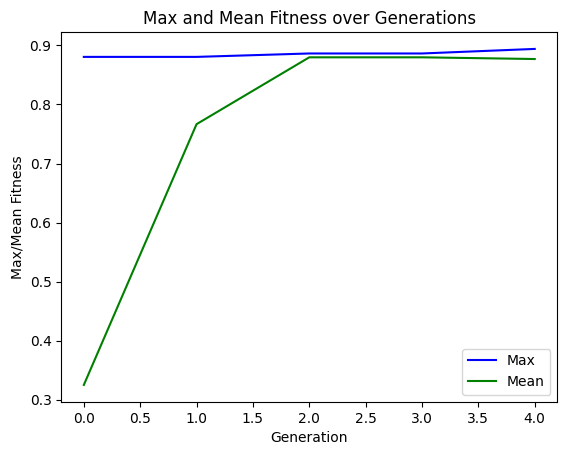


Best Num of neurons1:  68 
Best Num of neurons2:  77 
Best Epoch: 27


In [ ]:
best_individual = hof.items[0]
# best_num_neurons1 = None
# best_num_neurons2 = None
# best_epoch = None

# for bi in best_individual:
num_neurons1_bits = BitArray(best_individual[0:7])
num_neurons2_bits = BitArray(best_individual[7:14])
epoch_bits = BitArray(best_individual[14:])

best_num_neurons1 = num_neurons1_bits.uint
best_num_neurons2 = num_neurons2_bits.uint
best_epoch = epoch_bits.uint

maxFitnessValues,meanFitnessValues = logbook.select("max","avg")


# Plot the max and mean values
plt.plot(maxFitnessValues, color='blue')
plt.plot(meanFitnessValues, color='green')
plt.legend(('Max',"Mean"), loc='lower right')
plt.xlabel('Generation')
plt.ylabel('Max/Mean Fitness')
plt.title('Max and Mean Fitness over Generations')
plt.show()

print('\nBest Num of neurons1: ', best_num_neurons1, '\nBest Num of neurons2: ',
        best_num_neurons2,'\nBest Epoch:', best_epoch)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                       │ (None, 500, 68)             │          22,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 500, 68)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 77)                  │          44,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 77)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              78 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,350 (263.09 KB)

 Trainable params: 67,350 (263.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/27
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5824 - loss: 0.6649 - val_accuracy: 0.7249 - val_loss: 0.5413
Epoch 2/27
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7343 - loss: 0.5183 - val_accuracy: 0.8470 - val_loss: 0.3651
Epoch 3/27
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8410 - loss: 0.3791 - val_accuracy: 0.8625 - val_loss: 0.3269
Epoch 4/27
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8550 - loss: 0.3787 - val_accuracy: 0.8766 - val_loss: 0.2971
Epoch 5/27
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8464 - loss: 0.3452 - val_accuracy: 0.8933 - val_loss: 0.2877
Epoch 6/27
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8783 - loss: 0.3081 - val_accuracy: 0.8946 - val_loss: 0.2771
Epoch 7/27
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8692 - loss: 0.3236 - val_accuracy: 0.8869 - val_loss: 0.2758
Epoch 8/27
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8642 - loss: 0.3334 - val_accuracy: 0.8920 - v

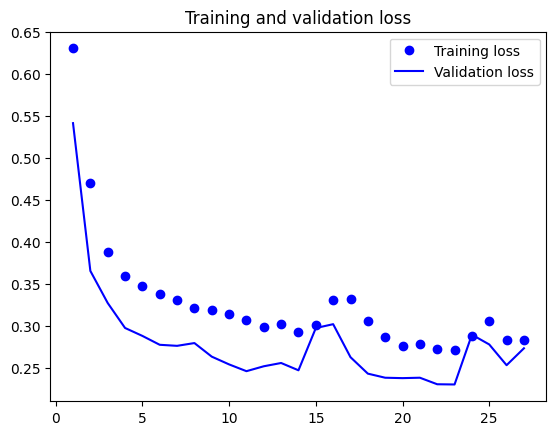

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8622 - loss: 0.3013
GA Optimized Model Test Accuracy: 85.65


In [ ]:
# from sklearn.metrics import accuracy_score
model = Sequential()
model.add(LSTM(units=best_num_neurons1, input_shape=(x_train_scaled.shape[1],x_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=best_num_neurons2))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
model.summary()

history=model.fit(x_train_scaled, y_train, validation_split = 0.3, epochs=best_epoch, batch_size=32)


import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


print(f"GA Optimized Model Test Accuracy: {model.evaluate(x=x_test_scaled,y=y_test)[1]*100:.2f}")
# print(f"Baseline Classifier Accuracy: {baseline_classifier(x_train,y_train,x_test,y_test)*100:.2f}")